In [21]:
# !pip install spacy
# !python -m spacy download ru_core_news_sm

# Кластеризация текста

## Загрузка данных

In [70]:
import pandas as pd
import os.path

from tqdm import tqdm

parent_dir = os.path.dirname(os.getcwd())

In [24]:
posts_df = pd.read_csv(os.path.join(parent_dir, "datasets/posts.csv"))
posts_df.iloc[11]

id                                                   1631877
text       С раннего детства я очень остро реагирую на ра...
likes                                                   1289
reposts                                                   95
views                                                 125185
Name: 11, dtype: object

In [25]:
posts_df.iloc[11]["text"]

'С раннего детства я очень остро реагирую на распускание рук. Как пелена опускалась, дыхание перехватывало и я уже думала только о том, как отомстить. Поэтому бабушка быстро оставила попытки "воспитания" ремнем, когда я тем же ремнем со всей силы ударила ее спящую. Помню, как начала лупить линейкой учительницу в первом классе, которая нас била по рукам за исправления... Вообще считаю, что дети, которых в детстве били родители, имеют право избивать их беспомощных в старости.\r\n\r\n#Подслушано_жестокость@overhear'

In [26]:
posts_df["tag"] = posts_df["text"].apply(lambda x: str(x).split("Подслушано")[-1].replace("\r\n\r\n#", "") if len(str(x).split("Подслушано")) > 1 else None)
posts_df["text"] = posts_df["text"].apply(lambda x: str(x).split("Подслушано")[0])

In [27]:
posts_df.iloc[10:15]["text"].tolist()

['Ничто не поднимает настроение лучше, чем тот факт, что моя бывшая через год после расставания уже успела в 21 год по залету выйти замуж и родить ребенка. Прям злодейски смеяться хочется от этого!\r\n\r\n#',
 'С раннего детства я очень остро реагирую на распускание рук. Как пелена опускалась, дыхание перехватывало и я уже думала только о том, как отомстить. Поэтому бабушка быстро оставила попытки "воспитания" ремнем, когда я тем же ремнем со всей силы ударила ее спящую. Помню, как начала лупить линейкой учительницу в первом классе, которая нас била по рукам за исправления... Вообще считаю, что дети, которых в детстве били родители, имеют право избивать их беспомощных в старости.\r\n\r\n#',
 'Ненавижу убираться, когда все дома. Тут же налетает вся семья и оказывается, что весь мусор — очень нужный мусор. Зато если выбросить, когда никто не видит, то даже не заметят!',
 'Когда мне было 10, умерла бабушка. Она на тот момент лежала в больнице, поэтому печальную новость нам сообщили, позво

In [28]:
posts_df["tag"] = posts_df["tag"].apply(lambda x: str(x).replace("@overhear", "").replace("\r", "").replace("\n", " ").replace("_", ""))
posts_df["text"] = posts_df["text"].apply(lambda x: str(x).replace("\r", "").replace("\n", " ").replace("\t", " "))
posts_df.head()

,id,text,likes,reposts,views,tag
0,1632037,Однажды делал своей девушке куни. В самый моме...,19,34,5518,пошлое
1,1632031,Живу с молодым человеком и его мамой (временна...,369,64,53145,провал
2,1632022,"Всегда презирала проституток, порноактрис. А п...",167,47,27266,None
3,1632004,"Подруга полгода пролежала в коме после аварии,...",307,184,71438,пиздец
4,1631999,"Когда вернулся из армии, моя бабушка умерла и ...",820,9,97900,успех


In [29]:
posts_df.nunique()

id         87994
text       87117
likes      20461
reposts     1378
views      78203
tag          202
dtype: int64

In [31]:
document = " ".join(posts_df["text"].to_list())

In [32]:
document[8990:9100]

'на 2 года старше. Отношения у нас продолжались до моих 17 лет. Налево бегала от него, дурочка. Такой взрослой '

## Очистка данных

In [57]:
import string

def clean_data(text: str) -> str:
    """Очистка данных."""
    _text = text.translate(str.maketrans('', '', string.punctuation)) # убираем знаки пунктуации
    _text = _text.translate(str.maketrans('', '', string.digits)) # убираем числа
    _text = _text.lower()
    return _text

In [58]:
clear_document = clean_data(document)

In [59]:
clear_document[1400:1500]

'кой дочкой помогла её мужу в быту оставалась ночевать когда у малышки резались зубки а я влюблена в '

## Анализ данных

In [54]:
import spacy

nlp = spacy.load("ru_core_news_sm")

In [115]:
for w in nlp(clear_document[100:200]):
    print(w.text, w.pos_)

оцессе NOUN
теперь ADV
эта DET
картина NOUN
никак ADV
не PART
выходит VERB
из ADP
моей DET
головы NOUN
как SCONJ
и PART
запах NOUN
   SPACE
живу VERB
с ADP
молодым ADJ
человеком NOUN
и CCONJ
е PROPN


In [63]:
len(clear_document) / nlp.max_length

36.502409

Будем разбивать наш текст для обработки на 37 частей

In [64]:
document_chunk = [clear_document[i:i+nlp.max_length] for i in range (0,len(clear_document), nlp.max_length)]

In [68]:
len(document_chunk[0])

1000000

Проанализируем каждый чанк

In [74]:
docs = []
for doc_chunk in tqdm(document_chunk):
    doc = nlp(doc_chunk)
    docs.append(doc)

100%|██████████| 37/37 [42:53<00:00, 69.56s/it]


Теперь из текстового документа можно найти существительные и глаголы.

Среди существительных выделить персон и организации.

In [116]:
words = []
nouns = []
verbs = []
people = []
orgs = []

In [117]:
for doc in tqdm(docs):
    for token in doc:
        if token.pos_ != 'SPACE' and token.pos_ != 'PUNCT':
            words.append(token.text)
        if token.pos_ == "VERB":
            verbs.append(token.text)

        if token.pos_ == "NOUN":
            nouns.append(token.text)

100%|██████████| 37/37 [00:10<00:00,  3.47it/s]


In [118]:
for doc in tqdm(docs):
    for ent in doc.ents:
        if ent.label_ == "ORG":
            orgs.append(ent.text)
        if ent.label_ == "PERSON":
            people.append(ent.text)

100%|██████████| 37/37 [00:00<00:00, 106.63it/s]


In [119]:
print("Всего слов: ", len(words))
print("Всего глаголов: ", len(verbs))
print("Всего существительных: ", len(nouns))
print("Всего людей: ", len(people))
print("Всего организаций: ", len(orgs))

Всего слов:  6087078
Всего глаголов:  1140503
Всего существительных:  1503712
Всего людей:  0
Всего организаций:  2402


In [86]:
print("Пример слова: ", words[100])
print("Пример глагола: ", verbs[20])
print("Пример существительного: ", nouns[10])
print("Пример организации: ", orgs[0])

Пример слова:  жужжащим
Пример глагола:  закрытые
Пример существительного:  недельку
Пример организации:  домодедово


Определим частоту слов

In [120]:
from collections import Counter
from collections import OrderedDict

def sort_by_frequency(data,reverse = True):
    """Сортировка данных по их частоте"""
    data_with_freq = dict(Counter(data))
    data_sorted_by_freq = OrderedDict(sorted(data_with_freq.items(), key=lambda x: x[1],reverse=reverse))

    return data_sorted_by_freq

In [121]:
words_freq = sort_by_frequency(words)
nouns_freq = sort_by_frequency(nouns)
verbs_freq = sort_by_frequency(verbs)
people_freq = sort_by_frequency(people)
orgs_freq = sort_by_frequency(orgs)

Рассмотрим наиболее частые слова

In [122]:
list(words_freq)[0:10]

['и', 'в', 'не', 'я', 'на', 'что', 'с', 'а', 'меня', 'у']

Как можно наблюдать, наиболее частые слова - это предлоги, союзы, местоимения.

Рассмотрим наиболее частые существительные

In [123]:
list(nouns_freq)[0:10]

['лет', 'раз', 'мама', 'день', 'время', 'муж', 'года', 'пор', 'жизни', 'жизнь']

Рассмотрим наиболее частые глаголы

In [124]:
list(verbs_freq)[0:10]

['нет',
 'есть',
 'могу',
 'говорит',
 'знаю',
 'хочу',
 'может',
 'люблю',
 'сказала',
 'решила']

Рассмотрим наиболее частых персон

In [125]:
list(people_freq)[0:10]

[]

Рассмотрим наиболее частые организации

In [126]:
list(orgs_freq)[0:10]

['ждём', 'сны', 'тц', 'мчс', 'тв', 'вконтакте', 'тд', 'гаи', 'telegram', 'чём']

## Анализ N-грамм

In [102]:
# !pip install nltk

  Using cached nltk-3.7-py3-none-any.whl (1.5 MB)
  Using cached regex-2022.3.15-cp39-cp39-win_amd64.whl (274 kB)
  Using cached joblib-1.1.0-py2.py3-none-any.whl (306 kB)


In [127]:
import nltk

def create_bigram(tokens: list) -> list:
    """Создание биграмм на основе токенов."""
    _bigrams = nltk.bigrams(tokens)
    return list(_bigrams)

In [128]:
bigrams_list = create_bigram(words)
bigrams = [" ".join(bigram) for bigram in list(bigrams_list)]

In [129]:
bigrams[100:110]

['одеялом смотрю',
 'смотрю на',
 'на неё',
 'неё она',
 'она на',
 'на меня',
 'меня а',
 'а у',
 'у нас',
 'нас оказывается']

Сортировка биграмм по частоте встречи

In [130]:
bigram_frequency = sort_by_frequency(bigrams)

Мы можем наблюдать частоту встречи биграмм

In [131]:
def get_top_n_from_order_dict(ordered_dict: OrderedDict,n: int) -> list:
    """Нахождение первых n-элементов из order dict."""
    return [list(ordered_dict.items())[i] for i in range(n)]

In [132]:
top_bigram = get_top_n_from_order_dict(bigram_frequency,25)

In [133]:
top_bigram

[('у меня', 17191),
 ('что я', 9383),
 ('я не', 8864),
 ('и не', 8658),
 ('а я', 7523),
 ('потому что', 6931),
 ('и я', 6872),
 ('у нас', 5846),
 ('не могу', 5222),
 ('не было', 4923),
 ('когда я', 4711),
 ('что это', 4577),
 ('так как', 4518),
 ('до сих', 4493),
 ('сих пор', 4448),
 ('никогда не', 4257),
 ('в детстве', 4154),
 ('что он', 4131),
 ('а потом', 4007),
 ('у него', 3905),
 ('и вот', 3898),
 ('с ним', 3848),
 ('и в', 3787),
 ('так и', 3745),
 ('ничего не', 3698)]

In [134]:
!pip install matplotlib

  Using cached matplotlib-3.5.1-cp39-cp39-win_amd64.whl (7.2 MB)
  Using cached Pillow-9.1.0-cp39-cp39-win_amd64.whl (3.3 MB)
  Using cached kiwisolver-1.4.2-cp39-cp39-win_amd64.whl (55 kB)
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
     -------------------------------------- 900.8/900.8 KB 2.7 MB/s eta 0:00:00


In [135]:
import numpy as np
import matplotlib.pyplot as plt

In [154]:
def visualize_list_of_tuple(data):
    """Визуализация списка кортежей."""
    list1, list2 = zip(*data)
    y_pos = np.arange(len(list1))
    plt.barh(y_pos, list2, align='center', alpha=0.5)
    plt.yticks(y_pos, list1)
    plt.show()

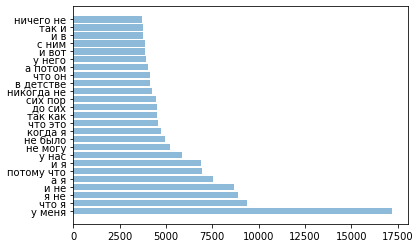

In [155]:
visualize_list_of_tuple(top_bigram)

Поиск уникальных существительных, глаголов, персон и организаций

In [156]:
unique_nouns = set(nouns)
unique_verbs = set(verbs)
unique_people = set(people)
unique_orgs = set(orgs)

Создадим биграммы с двумя существительными

In [161]:
def get_noun_noun_bigram(bigrams):
    """Поиск биграмм с двумя существительными."""
    NN_bigrams = []
    for first_word,second_word in bigrams:
        if first_word in unique_nouns and second_word in unique_nouns:
            NN_bigrams.append(" ".join((first_word,second_word)))
    return NN_bigrams
NN_bigrams = get_noun_noun_bigram(bigrams_list)

In [162]:
NN_bigrams[100:120]

['год после',
 'после расставания',
 'ребенка прям',
 'распускание рук',
 'попытки воспитания',
 'воспитания ремнем',
 'линейкой учительницу',
 'первом классе',
 'что дети',
 'старости ненавижу',
 'страх что',
 'что чтото',
 'день икс',
 'спокойным ребёнком',
 'кровать дома',
 'грузчики мама',
 'ключей дверь',
 'протяжении парытройки',
 'парытройки часов',
 'итоге мама']

Рассмотрим биграммы, где первым словом является глагол

In [163]:
def get_bigram_starting_with_verb(bigrams):
    """Выдать список биграмм, начинающихся с глагола."""
    V_bigrams = []
    for first_word,second_word in bigrams:
        if first_word in unique_verbs:
            V_bigrams.append(" ".join((first_word,second_word)))

    return V_bigrams
V_bigrams = get_bigram_starting_with_verb(bigrams_list)

In [165]:
V_bigrams[100:120]

['решила глянуть',
 'глянуть порно',
 'смотрела включила',
 'включила сразу',
 'доводит меня',
 'оргазм есть',
 'есть но',
 'хватает вспомнив',
 'вспомнив что',
 'когдато понравился',
 'понравился ролик',
 'нашла нечто',
 'дарят друг',
 'смеются я',
 'расплакалась я',
 'работаю секретарём',
 'стоит мфу',
 'бесит до',
 'ходят ко',
 'распечатываться чем']

Первое слово в биграмме организация

In [166]:
def get_bigram_starting_with_organization(bigrams):
    """Выдать биграммы, начинающиеся с организации."""
    org_bigrams = []
    for first_word,second_word in bigrams:
        if first_word in unique_orgs:
            org_bigrams.append(" ".join((first_word,second_word)))
    return org_bigrams
org_bigrams = get_bigram_starting_with_organization(bigrams_list)

In [167]:
org_bigrams[100:120]

['пёс заметила',
 'её к',
 'её числанули',
 'её со',
 'её попытки',
 'кхл или',
 'мхл а',
 'её заберут',
 'её балуют',
 'её мужем',
 'её люблю',
 'метрополь самая',
 'сны особенно',
 'сны на',
 'кино а',
 'пёс с',
 'отец его',
 'камаз соседка',
 'камаз уже',
 'тату жарптицу']

Первое слово персона

In [168]:
def get_bigram_starting_with_person(bigrams):
    people_bigrams = []
    for first_word,second_word in bigrams:
        if first_word in unique_people:
            people_bigrams.append(" ".join((first_word,second_word)))
    return people_bigrams
people_bigrams = get_bigram_starting_with_person(bigrams_list)

In [169]:
people_bigrams

[]

Сортировка по частоте слов

In [170]:
NN_bigrams_frequency = sort_by_frequency(NN_bigrams)
V_bigrams_frequency  = sort_by_frequency(V_bigrams)
people_bigrams_frequency = sort_by_frequency(people_bigrams)
org_bigrams_frequency = sort_by_frequency(org_bigrams)

In [171]:
list(NN_bigrams_frequency)[50:100]

['другом городе',
 'вроде бы',
 'а всё',
 'к родителям',
 'хочу чтобы',
 'ну а',
 'пор помню',
 'что муж',
 'какойто момент',
 'чувствую что',
 'детском саду',
 'мысли что',
 'что после',
 'что ктото',
 'время секса',
 'ну что',
 'гости к',
 'а муж',
 'после смерти',
 'к врачу',
 'тысяч рублей',
 'что хочу',
 'к другу',
 'т д',
 'пару недель',
 'к сожалению',
 'пару минут',
 'до утра',
 'том чтобы',
 'другую страну',
 'представляю что',
 'первом этаже',
 'что им',
 'всё бы',
 'что бы',
 'сказав что',
 'после развода',
 'что хочет',
 'это дело',
 'бывший муж',
 'ну думаю',
 'часа ночи',
 'бесят люди',
 'подхожу к',
 'к психологу',
 'до свадьбы',
 'пару часов',
 'после школы',
 'лет до',
 'что к']

In [172]:
list(V_bigrams_frequency)[50:100]

['то есть',
 'живу с',
 'оттого что',
 'её не',
 'её в',
 'то время',
 'смотрит на',
 'знала что',
 'училась в',
 'нет я',
 'были в',
 'жила в',
 'бесит когда',
 'думаю что',
 'говорю что',
 'одна из',
 'работала в',
 'может быть',
 'говорил что',
 'всё в',
 'както в',
 'была очень',
 'заметила что',
 'какоето время',
 'то я',
 'было мне',
 'была на',
 'жили в',
 'жить в',
 'подумала что',
 'встречаться с',
 'сказать что',
 'всё было',
 'еду в',
 'думал что',
 'ответила что',
 'её и',
 'её на',
 'была маленькая',
 'узнал что',
 'знает что',
 'было так',
 'жить с',
 'то и',
 'была маленькой',
 'попала в',
 'вижу что',
 'переехала в',
 'смотреть на',
 'считает что']

In [173]:
list(people_bigrams_frequency)[50:100]

[]

In [174]:
list(org_bigrams_frequency)[50:100]

['её уже',
 'отец ушёл',
 'её дочь',
 'чём я',
 'её так',
 'й год',
 'её смерти',
 'её сын',
 'дом не',
 'вк и',
 'блять не',
 'её мужем',
 'её у',
 'кино на',
 'её люблю',
 'дом с',
 'ято знаю',
 'вкус и',
 'её сына',
 'её подруга',
 'её же',
 'дом я',
 'её от',
 'дом у',
 'отец а',
 'минут после',
 'её стороны',
 'её мнению',
 'отец бросил',
 'её что',
 'её жизнь',
 'её лицо',
 'бабуля с',
 'её все',
 'её когда',
 'минут не',
 'тату на',
 'её жизни',
 'отец я',
 'отец сказал',
 'блять в',
 'её словам',
 'блять как',
 'её мне',
 'отец на',
 'кг при',
 'минут назад',
 'бабуля и',
 'её ещё',
 'telegram там']

Топ 25 биграмм с двумя существительными

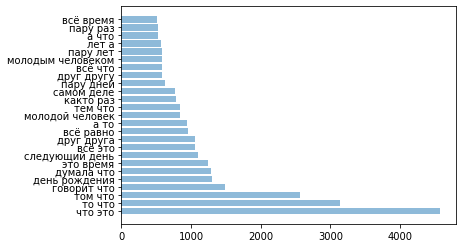

In [175]:
top_25_NN_bigram = get_top_n_from_order_dict(NN_bigrams_frequency,25)
visualize_list_of_tuple(top_25_NN_bigram)

## Кластеризация документов

In [181]:
!pip install scikit-learn

  Using cached scikit_learn-1.0.2-cp39-cp39-win_amd64.whl (7.2 MB)
  Using cached threadpoolctl-3.1.0-py3-none-any.whl (14 kB)
  Using cached scipy-1.8.0-cp39-cp39-win_amd64.whl (36.9 MB)


Очистим документ перед кластеризацией

In [176]:
documents = posts_df["text"].to_list()

In [179]:
cleaned_documents = []
for document in documents:
    document = clean_data(document).lower()
    cleaned_documents.append(document)
documents = cleaned_documents
documents[20]

'был в отношениях с девушкой  года жили вместе всё прекрасно это я так думал пока в один прекрасный день я вернувшись с работы домой не обнаружил что в нашей квартире живут другие люди мои вещи в сумках у соседей девушка вне зоны оказывается её папа поставил условие либо я либо ключи от новенькой машины как же я был слеп  '

In [182]:
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import time

In [200]:
class DocumentCluster:
    """Определение кластера докуманта."""
    def __init__(self,model,data):
        self.model = model
        self.data = data
        self.model_name = self._get_model_name()

        self.cluster_pipeline = None

    def _get_model_name(self):
        """Выдать название, используемой модели."""
        model_name = str(self.model).split('(')[0]
        return model_name

    def train_model(self,ngram: int,use_idf: bool):
        """Обучение модели."""
        current_time = time.time()

        self.cluster_pipeline = Pipeline([
            ('vect', CountVectorizer(ngram_range=(1,ngram), analyzer="word")),
            ('tfidf', TfidfTransformer(use_idf=use_idf)),
            ('model', self.model),
        ])
        self.cluster_pipeline.fit(self.data)
        train_time = time.time() - current_time

        print("Обучение модели завершено.")
        print(f"Модель {self.model_name} : {train_time} сек.")


    def predict(self):
        """Выдать кластер id."""
        self.document_id_dict = {}
        self.cluster_id = []
        for document in tqdm(self.data):
            cluster_id = self.cluster_pipeline.predict([document])[0]
            self.document_id_dict.update({document:cluster_id})
            self.cluster_id.append(cluster_id)

        return self.document_id_dict

Используем модель K-средних с 4 кластерами

In [201]:
cluster_num = 4

In [202]:
model = KMeans(n_clusters=cluster_num, init = "k-means++",max_iter=150,n_init=1)

In [203]:
doc_cluster = DocumentCluster(data=documents, model=model)

In [204]:
doc_cluster.train_model(ngram=2, use_idf=True)

Обучение модели завершено.
Модель KMeans : 91.98015928268433 сек.


In [205]:
result_docs = doc_cluster.predict()

100%|██████████| 87994/87994 [1:46:55<00:00, 13.72it/s]


In [214]:
clusters_text = []
for i in tqdm(range(cluster_num)):
    text = " ".join([k for k,v in result_docs.items() if v == i])
    clusters_text.append(text)

100%|██████████| 4/4 [00:00<00:00, 26.67it/s]


In [224]:
doc_cluster.cluster_id[0:20]

[2, 2, 2, 3, 2, 2, 2, 2, 2, 1, 2, 2, 2, 3, 2, 3, 2, 1, 2, 2]

Анализ биграмм всех кластеров

Возьмем так же первые 25 биграмм каждого кластера

In [240]:
def get_cluster_analysis_results(cluster_text: list):
    """Выдать результаты кластерного анализа."""
    clusters = {}

    for i, text in tqdm(enumerate(cluster_text)):
        if text == 'nan':
            continue
        tokens = text.split()
        # Используя токены слов, найдем биграммы
        bigram_list = create_bigram(tokens)
        bigrams = [" ".join(bigram) for bigram in list(bigram_list)]
        bigram_frequency = sort_by_frequency(bigrams)
        top_bigrams = get_top_n_from_order_dict(bigram_frequency,25)

        # Ищем биграммы с двумя существительными
        NN_bigrams = get_noun_noun_bigram(bigram_list)
        NN_bigrams_frequency = sort_by_frequency(NN_bigrams)
        top_NN_bigrams = get_top_n_from_order_dict(NN_bigrams_frequency,25)

        # Ищем биграммы, начиная с глагола
        V_bigrams = get_bigram_starting_with_verb(bigram_list)
        V_bigrams_frequency = sort_by_frequency(V_bigrams)
        top_V_bigrams = get_top_n_from_order_dict(V_bigrams_frequency,25)

        # # Ищем биграммы с персоной
        # people_bigrams = get_bigram_starting_with_person(bigram_list)
        # people_bigrams_frequency = sort_by_frequency(people_bigrams)
        # top_people_bigrams = get_top_n_from_order_dict(people_bigrams_frequency,25)

        # # Поиск биграмм с организацией
        # org_bigrams = get_bigram_starting_with_organization(bigram_list)
        # org_bigrams_frequency = sort_by_frequency(org_bigrams)
        # top_org_bigrams = get_top_n_from_order_dict(org_bigrams_frequency,25)


        cluster_analysis_result = {
            "bigram_freq":top_bigrams,
            "noun_noun_bigram":top_NN_bigrams,
            "verb_bigram":top_V_bigrams,
            # "people_bigram": top_people_bigrams,
            # "organization_bigram":top_org_bigrams,
        }
        clusters.update({i:cluster_analysis_result})
    return clusters

In [241]:
all_clusters = get_cluster_analysis_results(clusters_text)

4it [00:54, 13.64s/it]


Сравним различные биграммы из разных кластеров

In [245]:
def compare_bigram_of_clusters(comparision_parameter):
    """Создаем сравнительный DataFrame."""
    cluster_data = {}
    for cluster_id in tqdm(range(cluster_num)):
        try:
            cluster_result = all_clusters[cluster_id]
            data = cluster_result[comparision_parameter]
            bigram, frequency = zip(*data)
            col1 = "bigram_cluster_" + str(cluster_id)
            col2 = "bigram_freq_cluster_" + str(cluster_id)
            cluster_data.update({col1:bigram, col2: frequency})
        except:
            continue
    return pd.DataFrame(data=cluster_data)

In [246]:
df = compare_bigram_of_clusters("bigram_freq")
df

100%|██████████| 4/4 [00:00<00:00, 3998.38it/s]


,bigram_cluster_1,bigram_freq_cluster_1,bigram_cluster_2,bigram_freq_cluster_2,bigram_cluster_3,bigram_freq_cluster_3
0,у меня,4290,у меня,9140,у меня,3731
1,что он,3556,и не,4235,что она,2530
2,что я,2874,что я,4201,что я,2299
3,я не,2644,я не,4120,я не,2075
4,у него,2596,а я,3589,и не,1993
5,и не,2423,и я,3431,с ней,1884
6,с ним,2415,потому что,3242,у неё,1755
7,а я,2227,у нас,3024,потому что,1685
8,потому что,1997,не могу,2849,а я,1678
9,а он,1985,в детстве,2803,и я,1482


In [247]:
df = compare_bigram_of_clusters("noun_noun_bigram")
df

100%|██████████| 4/4 [00:00<?, ?it/s]


,bigram_cluster_1,bigram_freq_cluster_1,bigram_cluster_2,bigram_freq_cluster_2,bigram_cluster_3,bigram_freq_cluster_3
0,что это,1305,что это,2196,что это,1065
1,то что,900,то что,1401,то что,841
2,том что,767,том что,1184,том что,608
3,говорит что,568,день рождения,662,говорит что,511
4,думала что,408,думала что,620,день рождения,322
5,это время,401,а то,594,что её,318
6,молодой человек,392,это время,565,это время,277
7,друг друга,348,всё это,555,думала что,264
8,день рождения,316,следующий день,528,следующий день,260
9,следующий день,305,всё равно,506,что мама,230
